In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:08, 99.7MB/s]


Generating Image Generators for train and validation

In [22]:
batch_size = 128
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        '/content/PlantVillage/train', 
        target_size=(200, 200),  
        batch_size=batch_size,
        classes = classes_train,
        class_mode='categorical')
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        '/content/PlantVillage/val', 
        target_size=(200, 200),  
        batch_size=batch_size,
        classes = classes_train,
        class_mode='categorical')

Found 44016 images belonging to 39 classes.
Found 11004 images belonging to 39 classes.


Model Creation 



In [23]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(39, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        1

Compiling Model before training and testing

In [24]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0005),
              metrics=['acc'])

Creating callbacks and train

In [25]:
total_sample=train_generator.n
n_epochs = 30

checkpoint = keras.callbacks.ModelCheckpoint('/content/abc.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
tb = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')


history = model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=n_epochs,
        validation_data = val_generator,
        callbacks = [checkpoint, tb],
        verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
343/343 [==============================] - 123s 266ms/step - loss: 1.5101 - acc: 0.5963 - val_loss: 6.1763 - val_acc: 0.1264
Epoch 2/30
343/343 [==============================] - 88s 258ms/step - loss: 0.3676 - acc: 0.8878 - val_loss: 0.4946 - val_acc: 0.8432
Epoch 3/30
343/343 [==============================] - 88s 257ms/step - loss: 0.1965 - acc: 0.9368 - val_loss: 0.3143 - val_acc: 0.8971
Epoch 4/30
343/343 [==============================] - 87s 253ms/step - loss: 0.1242 - acc: 0.9609 - val_loss: 0.3401 - val_acc: 0.8947
Epoch 5/30
343/343 [==============================] - 87s 254ms/step - loss: 0.0878 - acc: 0.9720 - val_loss: 0.2842 - val_acc: 0.9094
Epoch 6/30
343/343 [==============================] - 88s 256ms/step - loss: 0.0633 - acc: 0.9799 - val_loss: 0.4603 - val_acc: 0.8826
Epoch 7/30
343/343 [==============================] - 87s 253ms/step - loss: 0.0470 - acc: 0.9844 - val_loss: 0.1706 - val_acc: 0.9485
Epoch 8/30
343/343 [==============================] - 

Saving model other than checkpoint

In [27]:
model.save('./modelv2')

INFO:tensorflow:Assets written to: ./modelv2/assets


In [28]:
model = tf.keras.models.load_model("modelv2")

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

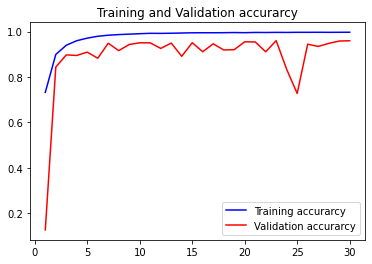

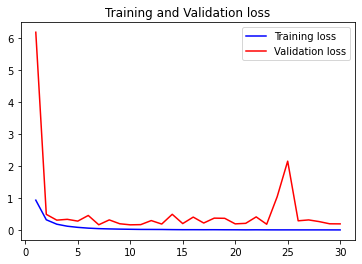

In [35]:
# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()